In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
def Heading(text,color='green'):
    print(colored("\033[1m"+'\033[4m' + text + '\033[0m'+"\033[0m",color))
def Bold(text):
    print("\033[1m"+text+"\033[0m")
def Print(text,color='blue'):
    print(colored("\033[1m"+text+"\033[0m",color))

hide_toggle()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
from termcolor import colored
from pylab import cm
import matplotlib.font_manager
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
colors = cm.get_cmap('tab20b', 10)
plt.rcParams['font.sans-serif'] = 'Verdana'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2

import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
Print("Importing Libraries")
hide_toggle()

Importing Libraries


In [28]:
Print('Crop Analysis for '+df_crop['Crop'].unique()[0])

Heading('Reading DataFrames')
Bold(' * df_coord - contains info about coordinates of districts')
Bold(' * df_soil - contains district wise soil info')
Bold(' * df_crop - contains info about crop district-wise yield')
Bold(' * df_cluster - dataset for clustering')
Bold(' * df_cluster_clustered - scaled dataset ready to do clustering')

df_coord=pd.read_csv('data/coordinates.csv')
df_soil_prop=pd.read_csv('data/soil_data_india_districts.csv')
df_crop=pd.read_csv('data/Wheat_processed.csv')
df_crop=df_crop[df_crop.Yield!=0]
df_soil=pd.merge(df_coord,df_soil_prop,on=['latitude','longitude']).dropna()
df_cluster=df_soil.drop(['State','District','latitude','longitude'],axis=1)
scaler = StandardScaler()
df_cluster_scaled=scaler.fit_transform(df_cluster)
df_crop=pd.merge(df_crop,df_soil,on=['State','District','latitude','longitude'])
hide_toggle()

Crop Analysis for Wheat
Reading DataFrames
 * df_coord - contains info about coordinates of districts
 * df_soil - contains district wise soil info
 * df_crop - contains info about crop district-wise yield
 * df_cluster - dataset for clustering
 * df_cluster_clustered - scaled dataset ready to do clustering


# Data Visualisation

Crop Analysis for Wheat
-------------------xxxxxxxxxxx--------------------------
count    8302.000000
mean        2.328537
std         1.147684
min         0.074698
25%         1.400000
50%         2.117429
75%         3.089457
max         7.461538
Name: Yield, dtype: float64
-------------------xxxxxxxxxxx--------------------------


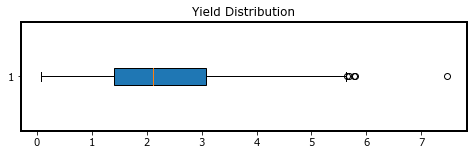

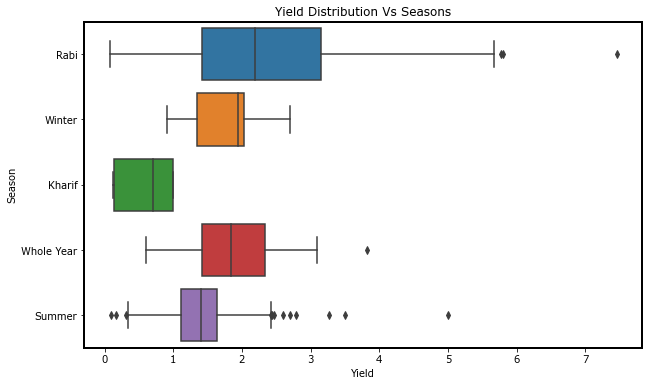

In [80]:
data=pd.read_csv('data/Wheat_processed.csv')

Heading('Crop Analysis for '+data['Crop'].unique()[0])

print('-------------------xxxxxxxxxxx--------------------------')
df_crop_train=df_crop[df_crop.Year<=2017]
df_crop_test=df_crop[df_crop.Year>2017]
df_crop_test['Preds']=np.nan
for index,row in df_crop_test.iterrows():
    df_crop_test.loc[index,'Preds']=df_crop_train[(df_crop_train.District==row['District'])&(df_crop_train.Season==row['Season'])].mean()['Yield']

Print(str(df_crop.Yield.describe()))
print('-------------------xxxxxxxxxxx--------------------------')

data=data.drop(['State','District','Crop','Area','Area Units','Production',
             'Production Units','latitude','longitude','Season','u10','v10','Year'],axis=1)

plt.figure(figsize=(8,2))
plt.title("Yield Distribution")
plt.boxplot(data=df_crop,x='Yield',vert=False,patch_artist=True)
plt.show()

plt.figure(figsize=(10,6))
plt.title("Yield Distribution Vs Seasons")
sns.boxplot(data=df_crop,x='Yield',y='Season')
plt.show()

hide_toggle()

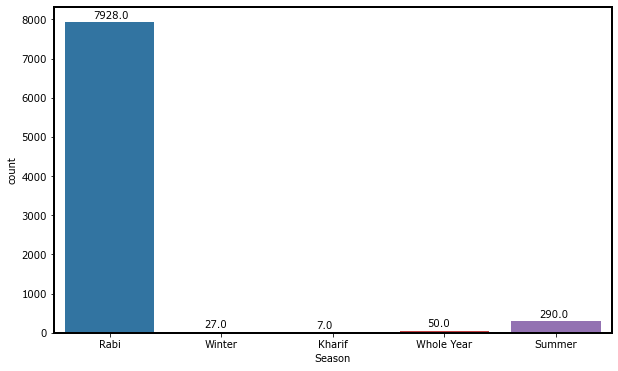

In [76]:
plt.figure(figsize=(10,6))
ax=sns.countplot(data=df_crop,x='Season')
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+100))
plt.show()
hide_toggle()

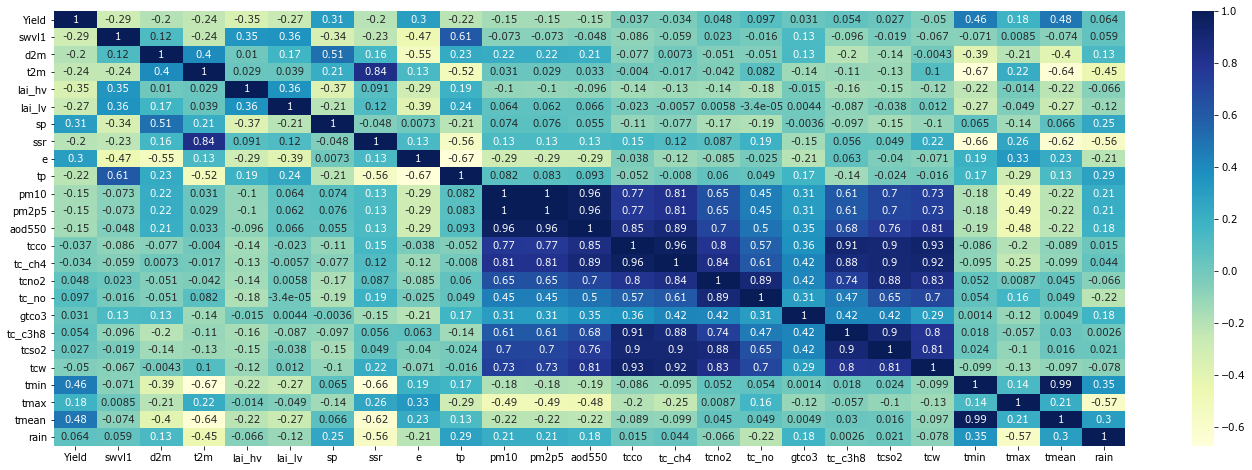

interactive(children=(Dropdown(description='Feature1_Y', options=('Yield', 'swvl1', 'd2m', 't2m', 'lai_hv', 'l…

In [81]:
plt.figure(figsize=(24,8))
sns.heatmap(data.corr(method ='spearman'), cmap='YlGnBu', annot=True) #Non Linear Corellation
plt.show()

def plot_corr(Feature1_Y,Feature2_X):
    data1=data.sample(1800)
    plt.scatter(data1[Feature2_X],data1[Feature1_Y],marker='x')
    plt.ylabel(Feature1_Y)
    plt.xlabel(Feature2_X)
    plt.title("Scatter plot b/w Features")
    plt.show()
a=data.columns
b=data.columns
interact(plot_corr,Feature1_Y=a,Feature2_X=b)
plt.show()
hide_toggle()

### Model 1: Elementary model / Dumb Model
The most "basic model" - is predicting mean of all years as yield efficiency for upcomming Years 

In [156]:
years=df_crop.Year.unique()
years.sort()
Print('Training Years:'+str(years[:-2]),'cyan')
Print('Prediction Years:'+str(years[-2:]),'green')

df_crop_train=df_crop[df_crop.Year<=2017]
df_crop_test=df_crop[df_crop.Year>2017]
df_crop_test['Preds']=np.nan
for index,row in df_crop_test.iterrows():
    df_crop_test.loc[index,'Preds']=df_crop_train[(df_crop_train.District==row['District'])&(df_crop_train.Season==row['Season'])].mean()['Yield']

Print('Predicting for '+str(len(df_crop_test))+' data points i.e '+str(100*round(len(df_crop_test)/(len(df_crop_test)+len(df_crop_train)),3))+'%')
Print('Model uses available District wise yield data and returns their mean as yield for the prediction year')
Print('Some crops werent grown in that district in a given season until 2017. So dropping '+str(df_crop_test.isna().sum()['Preds'])+' rows')
df_crop_test=df_crop_test.dropna()
print()

Heading('Stats of Dumb/Basic Model that predicts mean')
Print('  - MAE  : '+str(mean_absolute_error(df_crop_test['Yield'],df_crop_test['Preds'])))
Print('  - MAE% : '+str(mean_absolute_percentage_error(df_crop_test['Yield'],df_crop_test['Preds'])))

del df_crop_train,df_crop_test # Free up memory
hide_toggle() 

Training Years:[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Prediction Years:[2018 2019]
Predicting for 991 data points i.e 11.899999999999999%
Model uses available District wise yield data and returns their mean as yield for the prediction year
Some crops werent grown in that district in a given season until 2017. So dropping 18 rows

Stats of Dumb/Basic Model that predicts mean
  - MAE  : 0.5650785916512968
  - MAE% : 21.979164925938395


-------

### Model 2: Just Soil info for modelling
* Soil info was obtained from Gridded Soil Survey Geographic Database (gSSURGO) 
* It is spatial and not temporal data 
* Thus, we will be duplicating same soil data for a district across years
* If we use this for modelling it will and should perform bad and close to our dumb model 

Lets go ahead and verify it !

In [90]:
soil_cols=list(df_soil.columns)[4:]
df=df_crop[['District','Year','Yield']+soil_cols]
df_train=df[df.Year<=2017]
df_train.drop(['District','Year'],axis=1,inplace=True)
df_test=df[df.Year>2017]
df_test.drop(['District','Year'],axis=1,inplace=True)

X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
y_train=df_train[['Yield']].reset_index(drop=True)
y_test=df_test[['Yield']].reset_index(drop=True)
scaler = MinMaxScaler()
X_train_t=scaler.fit_transform(X_train)
X_test_t=scaler.transform(X_test)
scaler_out=MinMaxScaler()
y_train_t=scaler_out.fit_transform(y_train)
y_test_t=scaler_out.transform(y_test)

Print('Creating Model....','yellow')
model = xgb.XGBRegressor(n_estimators=200) #n_estimators is no of trees . More trees --> model becomes more complex 
model.fit(X_train_t,y_train_t)
Print('Modelling Completed','yellow')
print()

y_pred_train=scaler_out.inverse_transform(pd.DataFrame(model.predict(X_train_t)))
y_pred_test = scaler_out.inverse_transform(pd.DataFrame(model.predict(X_test_t)))

Heading('Model Stats')
table={1: ["R2 Score",round(r2_score(y_train,y_pred_train),3),round(r2_score(y_test,y_pred_test),3)],
       2: ["MAE ",round(mean_absolute_error(y_train,y_pred_train),3),round(mean_absolute_error(y_test,y_pred_test),3)],
       3: ["% MAE",str(round(mean_absolute_percentage_error(y_train,y_pred_train),3))+'%',str(round(mean_absolute_percentage_error(y_test,y_pred_test),3))+'%'],
       4: ["RMSE",round(mean_squared_error(y_train,y_pred_train),3),round(mean_squared_error(y_test,y_pred_test),3)],
}
Print("{:<8} {:<15} {:<10} {:<10}".format('S.No','Metrics','Train','Test'),'red')
for k, v in table.items():
    met, train_val, test_val = v
    Print ("{:<8} {:<15} {:<10} {:<10}".format(k, met, train_val, test_val))
    
del soil_cols,df,df_train,df_test,X_train,X_test,y_train,y_test,scaler,X_train_t,X_test_t,scaler_out,y_train_t
del y_test_t,model,y_pred_test,y_pred_train,met, train_val, test_val,table
hide_toggle()

Creating Model....
Modelling Completed

Model Stats
S.No     Metrics         Train      Test      
1        R2 Score        0.82       0.671     
2        MAE             0.351      0.573     
3        % MAE           21.253%    22.554%   
4        RMSE            0.226      0.51      


----
We have acheived results very close and actually this model performs bad as compared to [Dumb model](http://localhost:8888/notebooks/Cluster%20Agriculture/Untitled2.ipynb?kernel_name=python3#Model-1:-Elementary-model-/-Dumb-Model)

### Is Soil Data Waste ??

No definitely its not so and one of the most important parameters . Most research papers have used gSSURO data in their paper as well and its a assumption that soil properties dont change with time. If temporal data is available our model will perform much better. 

Future Scope : Implanting **low cost IOT devices** that can capture necessary soil info and it will boost our Model accuracy

### How do we use soil data ?

We can use **soil data to cluster districts with similar soil property** and create seperate models on those clusters 

Before that lets **create a model without soil Data**


------

### Model 3 : Meteo data model

* Wind (u10,v10) dew-point-temp
* Min Max Mean Temp
* Precepitation
* Pollutants : pm10 pm2.5 aod carbon-monoxide 


Creating Graphs for choosing right set of hyperparameters
Graphs for no of estimator vs metrics


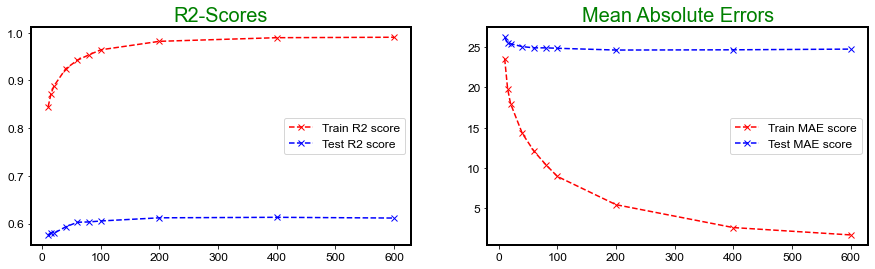

Choose Right Set of Hyperparameters


interactive(children=(Text(value='40', description='n_estimators'), Output()), _dom_classes=('widget-interact'…

In [93]:
soil_cols=list(pd.merge(df_coord,df_soil_prop,on=['latitude','longitude']).dropna().columns)[4:]
df_meteo=df_crop.drop(soil_cols,axis=1)
df_meteo.drop(['State','District','Crop','Area','Area Units','Production','Production Units'
               ,'latitude','longitude','Season'],axis=1,inplace=True)


df_train=df_meteo[df_meteo.Year<=2017]
df_train.drop(['Year'],axis=1,inplace=True)
df_test=df_meteo[df_meteo.Year>2017]
df_test.drop(['Year'],axis=1,inplace=True)

X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
y_train=df_train[['Yield']].reset_index(drop=True)
y_test=df_test[['Yield']].reset_index(drop=True)
scaler = MinMaxScaler()
X_train_t=scaler.fit_transform(X_train)
X_test_t=scaler.transform(X_test)
scaler_out=MinMaxScaler()
y_train_t=scaler_out.fit_transform(y_train)
y_test_t=scaler_out.transform(y_test)

Heading('Creating Graphs for choosing right set of hyperparameters')
# Hyperparmeter choosing
arr=[10,15,20,40,60,80,100,200,400,600]
train_r2=[]
test_r2=[]
train_mae_per=[]
test_mae_per=[]
for i in arr:
    m=xgb.XGBRegressor(n_estimators=i)
    m.fit(X_train_t,y_train_t)
    y_pred_train=scaler_out.inverse_transform(pd.DataFrame(m.predict(X_train_t)))
    y_pred_test = scaler_out.inverse_transform(pd.DataFrame(m.predict(X_test_t)))
    train_r2.append(r2_score(y_train,y_pred_train))
    test_r2.append(r2_score(y_test,y_pred_test))
    train_mae_per.append(mean_absolute_percentage_error(y_train,y_pred_train))
    test_mae_per.append(mean_absolute_percentage_error(y_test,y_pred_test))
Print('Graphs for no of estimator vs metrics')
plt.rcParams.update({'font.size': 12,'font.family':'Arial'})
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('R2-Scores',fontsize=20,color="green")
plt.plot(arr,train_r2,'rx--')
plt.plot(arr,test_r2,'bx--')
plt.legend(['Train R2 score','Test R2 score'])
plt.subplot(1,2,2)
plt.title('Mean Absolute Errors',fontsize=20,color="green")
plt.plot(arr,train_mae_per,'rx--')
plt.plot(arr,test_mae_per,'bx--')
plt.legend(['Train MAE score','Test MAE score'])
plt.show()

def f(n_estimators):
    
    soil_cols=list(pd.merge(df_coord,df_soil_prop,on=['latitude','longitude']).dropna().columns)[4:]
    df_meteo=df_crop.drop(soil_cols,axis=1)
    df_meteo.drop(['State','District','Crop','Area','Area Units','Production','Production Units'
               ,'latitude','longitude','Season'],axis=1,inplace=True)


    df_train=df_meteo[df_meteo.Year<=2017]
    df_train.drop(['Year'],axis=1,inplace=True)
    df_test=df_meteo[df_meteo.Year>2017]
    df_test.drop(['Year'],axis=1,inplace=True)

    X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
    X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
    y_train=df_train[['Yield']].reset_index(drop=True)
    y_test=df_test[['Yield']].reset_index(drop=True)
    scaler = MinMaxScaler()
    X_train_t=scaler.fit_transform(X_train)
    X_test_t=scaler.transform(X_test)
    scaler_out=MinMaxScaler()
    y_train_t=scaler_out.fit_transform(y_train)
    y_test_t=scaler_out.transform(y_test)

    if n_estimators=='':
        Print('Please enter a positive integer','red')
        n_estimators=200
        Print('Set n_estimator default:'+str(200))
        
        
    elif int(n_estimators)<10 or int(n_estimators)>1000:
        Print('Please enter a integer in range of 10-1000','red')
        n_estimators=200
        Print('Set n_estimator default:'+str(200))
        
    else:
        Print('Set n_estimator:'+str(n_estimators))
        
        

    Print('Creating Model....','yellow')
        
    model = xgb.XGBRegressor(n_estimators=int(n_estimators)) #n_estimators is no of trees . More trees --> model becomes more complex 
    model.fit(X_train_t,y_train_t)
    Print('Modelling Completed','yellow')
    print()

    y_pred_train=scaler_out.inverse_transform(pd.DataFrame(model.predict(X_train_t)))
    y_pred_test = scaler_out.inverse_transform(pd.DataFrame(model.predict(X_test_t)))

    Heading('Model Stats')
    table={1: ["R2 Score",round(r2_score(y_train,y_pred_train),3),round(r2_score(y_test,y_pred_test),3)],
       2: ["MAE ",round(mean_absolute_error(y_train,y_pred_train),3),round(mean_absolute_error(y_test,y_pred_test),3)],
       3: ["% MAE",str(round(mean_absolute_percentage_error(y_train,y_pred_train),3))+'%',str(round(mean_absolute_percentage_error(y_test,y_pred_test),3))+'%'],
       4: ["RMSE",round(mean_squared_error(y_train,y_pred_train),3),round(mean_squared_error(y_test,y_pred_test),3)],
    }
    Print("{:<8} {:<15} {:<10} {:<10}".format('S.No','Metrics','Train','Test'),'red')
    for k, v in table.items():
        met, train_val, test_val = v
        Print ("{:<8} {:<15} {:<10} {:<10}".format(k, met, train_val, test_val))    
Print('Choose Right Set of Hyperparameters')
interact(f, n_estimators='40')
del soil_cols,df_meteo,df_train,df_test,X_train,X_test,y_train,y_test,scaler,X_train_t,X_test_t,scaler_out,y_train_t
del y_test_t,m,y_pred_test,y_pred_train
hide_toggle()

---
### Model 4: Meteo + Soil Data Model

Creating Graphs for choosing right set of hyperparameters
Graphs for no of estimator vs metrics


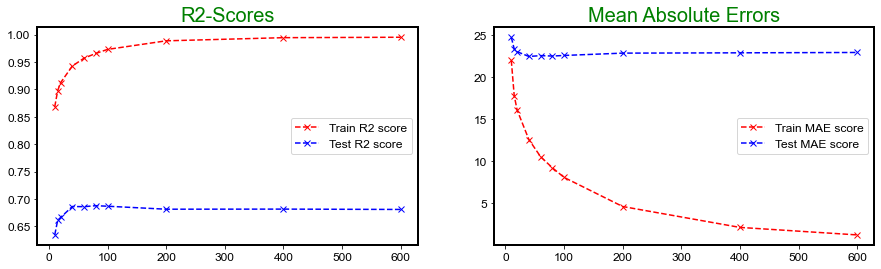

Choose Right Set of Hyperparameters


interactive(children=(Text(value='60', description='n_estimators'), Output()), _dom_classes=('widget-interact'…

In [95]:
df_meteo=df_crop.copy()
df_meteo.drop(['State','District','Crop','Area','Area Units','Production','Production Units'
               ,'latitude','longitude','Season'],axis=1,inplace=True)


df_train=df_meteo[df_meteo.Year<=2017]
df_train.drop(['Year'],axis=1,inplace=True)
df_test=df_meteo[df_meteo.Year>2017]
df_test.drop(['Year'],axis=1,inplace=True)

X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
y_train=df_train[['Yield']].reset_index(drop=True)
y_test=df_test[['Yield']].reset_index(drop=True)
scaler = MinMaxScaler()
X_train_t=scaler.fit_transform(X_train)
X_test_t=scaler.transform(X_test)
scaler_out=MinMaxScaler()
y_train_t=scaler_out.fit_transform(y_train)
y_test_t=scaler_out.transform(y_test)

Heading('Creating Graphs for choosing right set of hyperparameters')
# Hyperparmeter choosing
arr=[10,15,20,40,60,80,100,200,400,600]
train_r2=[]
test_r2=[]
train_mae_per=[]
test_mae_per=[]
for i in arr:
    m=xgb.XGBRegressor(n_estimators=i)
    m.fit(X_train_t,y_train_t)
    y_pred_train=scaler_out.inverse_transform(pd.DataFrame(m.predict(X_train_t)))
    y_pred_test = scaler_out.inverse_transform(pd.DataFrame(m.predict(X_test_t)))
    train_r2.append(r2_score(y_train,y_pred_train))
    test_r2.append(r2_score(y_test,y_pred_test))
    train_mae_per.append(mean_absolute_percentage_error(y_train,y_pred_train))
    test_mae_per.append(mean_absolute_percentage_error(y_test,y_pred_test))
Print('Graphs for no of estimator vs metrics')
plt.rcParams.update({'font.size': 12,'font.family':'Arial'})
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title('R2-Scores',fontsize=20,color="green")
plt.plot(arr,train_r2,'rx--')
plt.plot(arr,test_r2,'bx--')
plt.legend(['Train R2 score','Test R2 score'])
plt.subplot(1,2,2)
plt.title('Mean Absolute Errors',fontsize=20,color="green")
plt.plot(arr,train_mae_per,'rx--')
plt.plot(arr,test_mae_per,'bx--')
plt.legend(['Train MAE score','Test MAE score'])
plt.show()

def f(n_estimators):
    
    df_meteo=df_crop.copy()
    df_meteo.drop(['State','District','Crop','Area','Area Units','Production','Production Units'
               ,'latitude','longitude','Season'],axis=1,inplace=True)


    df_train=df_meteo[df_meteo.Year<2017]
    df_train.drop(['Year'],axis=1,inplace=True)
    df_test=df_meteo[df_meteo.Year>=2017]
    df_test.drop(['Year'],axis=1,inplace=True)

    X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
    X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
    y_train=df_train[['Yield']].reset_index(drop=True)
    y_test=df_test[['Yield']].reset_index(drop=True)
    scaler = MinMaxScaler()
    X_train_t=scaler.fit_transform(X_train)
    X_test_t=scaler.transform(X_test)
    scaler_out=MinMaxScaler()
    y_train_t=scaler_out.fit_transform(y_train)
    y_test_t=scaler_out.transform(y_test)

    if n_estimators=='':
        Print('Please enter a positive integer','red')
        n_estimators=200
        Print('Set n_estimator default:'+str(200))
        
        
    elif int(n_estimators)<10 or int(n_estimators)>1000:
        Print('Please enter a integer in range of 10-1000','red')
        n_estimators=200
        Print('Set n_estimator default:'+str(200))
        
    else:
        Print('Set n_estimator:'+str(n_estimators))
        
        

    Print('Creating Model....','yellow')
        
    model = xgb.XGBRegressor(n_estimators=int(n_estimators)) #n_estimators is no of trees . More trees --> model becomes more complex 
    model.fit(X_train_t,y_train_t)
    Print('Modelling Completed','yellow')
    print()

    y_pred_train=scaler_out.inverse_transform(pd.DataFrame(model.predict(X_train_t)))
    y_pred_test = scaler_out.inverse_transform(pd.DataFrame(model.predict(X_test_t)))

    Heading('Model Stats')
    table={1: ["R2 Score",round(r2_score(y_train,y_pred_train),3),round(r2_score(y_test,y_pred_test),3)],
       2: ["MAE ",round(mean_absolute_error(y_train,y_pred_train),3),round(mean_absolute_error(y_test,y_pred_test),3)],
       3: ["% MAE",str(round(mean_absolute_percentage_error(y_train,y_pred_train),3))+'%',str(round(mean_absolute_percentage_error(y_test,y_pred_test),3))+'%'],
       4: ["RMSE",round(mean_squared_error(y_train,y_pred_train),3),round(mean_squared_error(y_test,y_pred_test),3)],
    }
    Print("{:<8} {:<15} {:<10} {:<10}".format('S.No','Metrics','Train','Test'),'red')
    for k, v in table.items():
        met, train_val, test_val = v
        Print ("{:<8} {:<15} {:<10} {:<10}".format(k, met, train_val, test_val))    
Print('Choose Right Set of Hyperparameters')
interact(f, n_estimators='60')
del df_meteo,df_train,df_test,X_train,X_test,y_train,y_test,scaler,X_train_t,X_test_t,scaler_out,y_train_t
del y_test_t,m,y_pred_test,y_pred_train
hide_toggle()

Right!! So our **model3(meteorological data)** and **model4(meteo+soil)** performs worser than our Dumb and Soil data model.

We can cluster data based on Soil Features .
Then train different models on different clusters

###  Model 3 : Clustering based on similar soil properties and then modeling using weather data


In [96]:
"""
Naming conventions slightly diff for 2 df. 
Function to account plotting correcting the naming
"""
print('Contains function that helps us show districts on an Indian Map')

def rename_districts(district_name): 
    to_rename={
        # Gujarat
        'Aravalli':'Arvali','Chhotaudepur':'Chhota Udaipur','Botad':'Batod','Dang':'The Dangs','Leh Ladakh':'Leh (Ladakh)',
        # Karnataka
        'Chikballapur':'Chikkaballapura','Dakshin Kannad':'Dakshina Kannada','Uttar Kannad':'Uttara Kannada','Davangere':'Davanagere',
        'Bengaluru Urban':'Bangalore','Purba Bardhaman':'Barddhaman','Purulia':'Puruliya','Medinipur West':'Paschim Medinipur',

        #West Bengal
        'Hooghly':'Hugli','Dinajpur Dakshin':'Dakshin Dinajpur','Coochbehar':'Koch Bihar','Purba Bardhaman':'Barddhaman',
        'Purulia':'Puruliya','Medinipur West':'Paschim Medinipur','Darjeeling':'Darjiling','Dinajpur Uttar':'Uttar Dinajpur',
        'Medinipur West':'Purba Medinipur','Howrah':'Haora',
        # Telengana
        'Warangal':'Warangal (R)','Jangoan':'Jangaon','Rangareddi':'Rangareddy','Komaram Bheem Asifabad':'Komaram Bheem',
        'Jagitial':'Jagtial','Warangal Urban':'Warangal (U)','Mahbubnagar':'Mahabubnagar',
        # Uttar Pradesh
        'Sant Ravidas Nagar':'Sant Ravidas Nagar (Bhadohi)','Siddharth Nagar':'Siddharthnagar',
        'Sant Kabeer Nagar':'Sant Kabir Nagar','Barabanki':'Bara Banki','Maharajganj':'Mahrajganj','Kushi Nagar':'Kushinagar',
        'Samli':'Shamli',
        #Bihar
        'Purbi Champaran':'Purba Champaran',
        #Meghalaya
        'Ri Bhoi':'Ribhoi',
        #Goa
        'Goa':'South Goa',
        #Assam
        'Kamrup Metro':'Kamrup Metropolitan',
        #
        'Lahul And Spiti':'Lahul & Spiti',
        #Tripura
        'Unakoti':'Unokoti','Sepahijala':'Sipahijula',
        #AP
        'Kadappa':'Kadapa(Ysr)','Visakhapatanam':'Visakhapatnam','Spsr Nellore':'Sri Potti Sriramulu Nellore',
        #MP
        'Khandwa (East Nimar)':'Khandwa','Narsinghpur':'Narsimhapur','Khargone':'Khargone (West Nimar)',
        # Rajasthan
        'Jhunjhunu':'Jhunjhunun','Chittorgarh':'Chittaurgarh','Jalore':'Jalor','Dholpur':'Dhaulpur',
        #TN
        'Thoothukudi':'Thoothukkudi','Kanchipuram':'Kancheepuram','Villupuram':'Viluppuram',
        #Maharashtra
        'Ahmadnagar':'Ahmednagar','Gondiya':'Gondia','Buldana':'Buldhana','Bid':'Beed','Mumbai Suburban':'Mumbai',
        #chattisgargh
        'Bemetara':'Bemetra','Gariyaband':'Gariaband','Kabirdham':'Kabeerdham','Kanker':'Uttar Bastar Kanker',
        'Dantewada':'Dakshin Bastar Dantewada','Surajpur':'Surguja',
        #Odhisa
        'Nabarangpur':'Nabarangapur','Deogarh':'Debagarh','Boudh':'Baudh',
        #Uttarakhand
        'Uttar Kashi':'Uttarkashi','Tehri Garhwal':'Garhwal','Haridwar':'Hardwar','Rudra Prayag':'Rudraprayag',
        'Udam Singh Nagar':'Udham Singh Nagar',
        #Jharkhand
        'Saraikela Kharsawan':'Saraikela-Kharsawan','West Singhbhum':'Pashchimi Singhbhum','East Singhbum':'Purbi Singhbhum',
        'Koderma':'Kodarma','Sahebganj':'Sahibganj',

        'Pondicherry':'Puducherry','Shopian':'Shupiyan','Baramulla':'Baramula','Rajauri':'Rajouri',
        'Poonch':'Punch','Bandipora':'Bandipore'
    }
    if district_name in to_rename:
        return to_rename[district_name]
    return district_name
import seaborn as sns
import geopandas as gpd
import shapefile as shp
from shapely import wkt
from shapely.geometry import Point
def plot_india(df):
    df_districts=pd.read_csv('districts_india.csv')
    df_districts.distname=df_districts.distname.str.title()
    df_districts.rename(columns={'distname':'District'},inplace=True)
    df_districts.drop('totalpopul',axis=1,inplace=True)
    df=df.drop('State',axis=1)
    df['District']=df['District'].str.title()
    df['District']=df['District'].apply(rename_districts)    
    x=pd.merge(df_districts,df,how='left').reset_index(drop=True)
    x=x[x.geometry.notna()].reset_index(drop=True)
    x['cluster'] =x['cluster'].fillna(-1).astype(int)
    x['cluster']=x['cluster'].replace(-1,np.nan)
    x['geometry'] = x['geometry'].apply(wkt.loads)
    sns.set_style('whitegrid')
    gpd.GeoDataFrame(x, geometry = 'geometry').plot(column='cluster',
                                                cmap=cm.get_cmap('Accent', df.cluster.nunique()), # use Set1/tab20c/tab20b/Accent
                                                #legend=True,
                                                missing_kwds={"color": "white","hatch": "///","label": "Missing values"},
                                                legend_kwds={'label': "Soil Based Clustering",
                                                             'orientation': "vertical"}, 
                                                edgecolor='k',figsize=(90, 15)).set_axis_off()


    plt.show()
hide_toggle()

Contains function that helps us show districts on an Indian Map


In [163]:
Print('Choose the Clustering technique using DropDown:')
from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

colors = cm.get_cmap('tab20b', 10)


n_cluster=5

def cluster_options(option):
    #clear_output()
    
    global df_final
    
    if option=='K-means':
        Print('Creating Elbow Plot....','green')   
        sse={}
        for i in range(2,40,2):
            km = KMeans(n_clusters=i, random_state=42,init='k-means++',n_init=20)
            km.fit(df_cluster_scaled)
            sse[i]=km.inertia_
        plt.figure(figsize=(8,4))
        plt.plot(list(sse.keys()),list(sse.values()),'--o',label='sse',linewidth=3, color=colors(2))
        plt.xticks(range(list(sse.keys())[0],list(sse.keys())[-1]+2,2))
        plt.xlabel('Number of Clusters')
        plt.ylabel('SSE score')
        print('8888')
        plt.show()
        Print('Creating Model with n_estimators='+str(n_cluster)+' ...','green')   

        km = KMeans(n_clusters=int(n_cluster), random_state=42,init='k-means++',n_init=20)
        km.fit(df_cluster_scaled)
        cluster=km.predict(df_cluster_scaled)
        
        

    if option=='Agglomerative Clustering':
        ag = AgglomerativeClustering(n_clusters=int(n_cluster))
        ag.fit(df_cluster_scaled)
        cluster=ag.labels_
        
    df_soil['cluster']=cluster    
    df_final=df_soil[['State','District','cluster']]
    Print('Creating Indian Map for Visualisation....','green')
    plot_india(df_final)
    return 
interact(cluster_options,option=['K-means','Agglomerative Clustering'])
plt.show()

Choose the Clustering technique using DropDown:


interactive(children=(Dropdown(description='option', options=('K-means', 'Agglomerative Clustering'), value='K…

In [152]:
c=df_final.cluster.unique()
c.sort()
train_mae=[]
train_mae_perc=[]
test_mae=[]
test_mae_perc=[]
train_r2=[]
test_r2=[]
Heading('FITTING '+str(len(c))+' CLUSTERS.....','green')
for i in c:
    cluster_i_df=df_final[df_final.cluster==i]
    df_crop_cluster=pd.merge(cluster_i_df,df_crop,on=['State','District'])
    df_crop_cluster.drop(['State','District','Crop','Area','Area Units','Production','Production Units','latitude',
                          'longitude','cluster'],axis=1,inplace=True)
    df_crop_cluster=pd.get_dummies(df_crop_cluster)
    df_train=df_crop_cluster[(df_crop_cluster.Year>=2003)&(df_crop_cluster.Year<=2017)]
    df_test=df_crop_cluster[(df_crop_cluster.Year>2017)]
    X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
    X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
    y_train=df_train[['Yield']].reset_index(drop=True)
    y_test=df_test[['Yield']].reset_index(drop=True)
    scaler = MinMaxScaler()
    X_train_t=scaler.fit_transform(X_train)
    X_test_t=scaler.transform(X_test)
    scaler_out=MinMaxScaler()
    y_train_t=scaler_out.fit_transform(y_train)
    y_test_t=scaler_out.transform(y_test)
    print(colored('Fitting Model for cluster '+str(i+1),'blue',attrs=['blink']))
    model = xgb.XGBRegressor(n_estimators=400) #n_estimators is no of trees . More trees --> model becomes more complex 15
    model.fit(X_train_t,y_train_t)
    
    y_pred_train=scaler_out.inverse_transform(pd.DataFrame(model.predict(X_train_t)))
    y_pred_test = scaler_out.inverse_transform(pd.DataFrame(model.predict(X_test_t)))
    
    train_mae.append(mean_absolute_error(y_train,y_pred_train))
    test_mae.append(mean_absolute_error(y_test,y_pred_test))
    
    train_mae_perc.append(mean_absolute_percentage_error(y_train,y_pred_train))
    test_mae_perc.append(mean_absolute_percentage_error(y_test,y_pred_test))
    
    train_r2.append(r2_score(y_train,y_pred_train))
    test_r2.append(r2_score(y_test,y_pred_test))
table={"Train Mae %":train_mae_perc,
       "Test MAE %": test_mae_perc,
       "Train Mae":train_mae,
       "Test MAE ": test_mae,
       "Train R2": train_r2,
       "Test R2": test_r2}
table=pd.DataFrame(table).transpose()
mean=table.transpose().mean()
table['mean']=mean
display(table)  
hide_toggle()

FITTING 5 CLUSTERS.....
Fitting Model for cluster 1
Fitting Model for cluster 2
Fitting Model for cluster 3
Fitting Model for cluster 4
Fitting Model for cluster 5


,0,1,2,3,4,mean
Train Mae %,0.270781,1.628465,2.216696,0.235262,1.481360,1.166513
Test MAE %,27.251534,23.834829,20.848825,17.989926,20.352893,22.055601
Train Mae,0.004071,0.035835,0.027686,0.006168,0.019958,0.018744
Test MAE,0.466452,0.671007,0.431513,0.624294,0.380948,0.514843
Train R2,0.999915,0.988310,0.971360,0.999949,0.993881,0.990683
Test R2,0.763131,0.401368,0.600669,0.631384,0.790128,0.637336


In [162]:
def plot_dist(district_name,season):
    
    clus_no=list(df_final[df_final.District==district_name]['cluster'])[0]   
    cluster_i_df=df_final[df_final.cluster==clus_no]
    df_crop_cluster=pd.merge(cluster_i_df,df_crop,on=['State','District'])
    df_crop_cluster.drop(['State','District','Crop','Area','Area Units','Production','Production Units','latitude',
                          'longitude','cluster','Season'],axis=1,inplace=True)
    df_crop_cluster=pd.get_dummies(df_crop_cluster)
    df_train=df_crop_cluster[(df_crop_cluster.Year>=2003)&(df_crop_cluster.Year<=2017)]
    df_test=df_crop_cluster[(df_crop_cluster.Year>2017)]
    X_train=df_train.drop('Yield',axis=1).reset_index(drop=True)
    X_test=df_test.drop('Yield',axis=1).reset_index(drop=True)
    y_train=df_train[['Yield']].reset_index(drop=True)
    y_test=df_test[['Yield']].reset_index(drop=True)
    scaler = MinMaxScaler()
    X_train_t=scaler.fit_transform(X_train)
    X_test_t=scaler.transform(X_test)
    scaler_out=MinMaxScaler()
    y_train_t=scaler_out.fit_transform(y_train)
    y_test_t=scaler_out.transform(y_test)
    model = xgb.XGBRegressor(n_estimators=400) #n_estimators is no of trees . More trees --> model becomes more complex 
    model.fit(X_train_t,y_train_t)
    df_crop_cluster=pd.merge(cluster_i_df,df_crop,on=['State','District'])
    df_crop_cluster=df_crop_cluster.sort_values(by='Year')
    yr=list(df_crop_cluster[(df_crop_cluster.District==district_name)&(df_crop_cluster.Season==season)]['Year'])
    actual=list(df_crop_cluster[(df_crop_cluster.District==district_name)&(df_crop_cluster.Season==season)]['Yield'])
    pred1=list(df_crop_cluster[(df_crop_cluster.District==district_name)&(df_crop_cluster.Year<=2017)&(df_crop_cluster.Season==season)]['Yield']) 
    test_dist_df=df_crop_cluster[(df_crop_cluster.District==district_name)&(df_crop_cluster.Year>2017)&(df_crop_cluster.Season==season)]    
    test_dist_df_dummy=[np.mean(pred1)]*len(test_dist_df)
    
    if len(test_dist_df)==0:
        Print('No Data Points available, Choose another District !!','red')
        
        
    else:
        #d=test_dist_df[['State','District','cluster','Yield']].duplicated()
        #test_dist_df=test_dist_df[~d]
        test_dist_df.drop(['State','District','Crop','Area','Area Units','Production','Production Units','latitude',
                          'longitude','cluster','Season','Yield'],axis=1,inplace=True)
        x=scaler_out.inverse_transform(pd.DataFrame(model.predict(scaler.transform(test_dist_df))))
        pred=pred1+list(x.reshape(-1))
        pred_dummy=pred1+test_dist_df_dummy
        
        plt.figure(figsize=(10,4))
        plt.rcParams['font.size'] = 12
        Print('Data available: '+str(yr))
        Print('Predicted Yield for years: '+str(yr[-len(test_dist_df):]),'green')
        plt.plot(yr,actual,'o-',color='red',linewidth=3)
        plt.plot(yr,pred_dummy,'x--',color='b') 
        plt.plot(yr,pred,'x--',color='k') 
        
        plt.xticks(range(2002,2020,1))
        plt.legend(['actual','predicted','Dumb Mean Model'])
        plt.xlabel('Years',fontsize=14,color='k')
        plt.ylabel('Yield',fontsize=14,color='k')
        plt.title('Yield for '+list(df_crop.Crop.unique())[0]+' in '+district_name,fontsize=17,color='b')
        plt.show()
    
        
    
    
    

a=list(df_crop.District.unique())
a.sort()       
b=df_crop.Season.unique()
interact(plot_dist,district_name=a,season=b)
hide_toggle()

interactive(children=(Dropdown(description='district_name', options=('ADILABAD', 'AGAR MALWA', 'AGRA', 'AHMADA…